In [3]:
import os
import cv2
from glob import glob
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from tqdm import tqdm

TRAIN_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
size=256
save_folder = f"/kaggle/dataset/volume_{size}"

In [5]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype
        pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2

    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array


def interpolate_volume(volume, vol_size=None):
    volume = torch.tensor(volume, dtype=torch.float32)
    vol_shape = tuple(volume.shape)
    if not vol_size:
        d_new = min(vol_shape[:2])
        vol_size = (vol_shape[0], vol_shape[1], d_new)
    if vol_shape == vol_size:
        return volume.numpy()
    interpolated = F.interpolate(volume.unsqueeze(0).unsqueeze(0), size=vol_size, mode="trilinear", align_corners=False)[0, 0]

    return interpolated.numpy()


def process(patient, save_folder, data_path, size=(512, 512, 512)):
    for study in sorted(os.listdir(data_path + patient)):
        save_path = os.path.join(save_folder, f"{patient}_{study}.npy")
        if os.path.exists(save_path):continue
        imgs = {}
        for dcm in sorted(glob(os.path.join(data_path, f"{patient}/{study}/*.dcm"))):
            dicom = pydicom.dcmread(dcm)

            pos_z = dicom[(0x20, 0x32)].value[-1]

            img = standardize_pixel_array(dicom)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img
            # img = cv2.resize(img, size[:2], interpolation=cv2.INTER_LINEAR)
            imgs[pos_z] = img

        sorted_keys = sorted(imgs.keys(), reverse=True)
        result_array = np.array([imgs[key] for key in sorted_keys])
        print(result_array.shape)
        # result_array = interpolate_volume(result_array, size)
        # save_path = os.path.join(save_folder, f"{patient}_{study}.npy")
        # np.save(save_path, result_array.astype(np.float16),)


In [7]:
os.makedirs(save_folder, exist_ok=True)
for patient in tqdm(os.listdir(TRAIN_PATH)):
    print(patient)
    # process(patient, save_folder, TRAIN_PATH, (size,size,size))
    break

  0%|          | 0/3147 [00:00<?, ?it/s]

10004


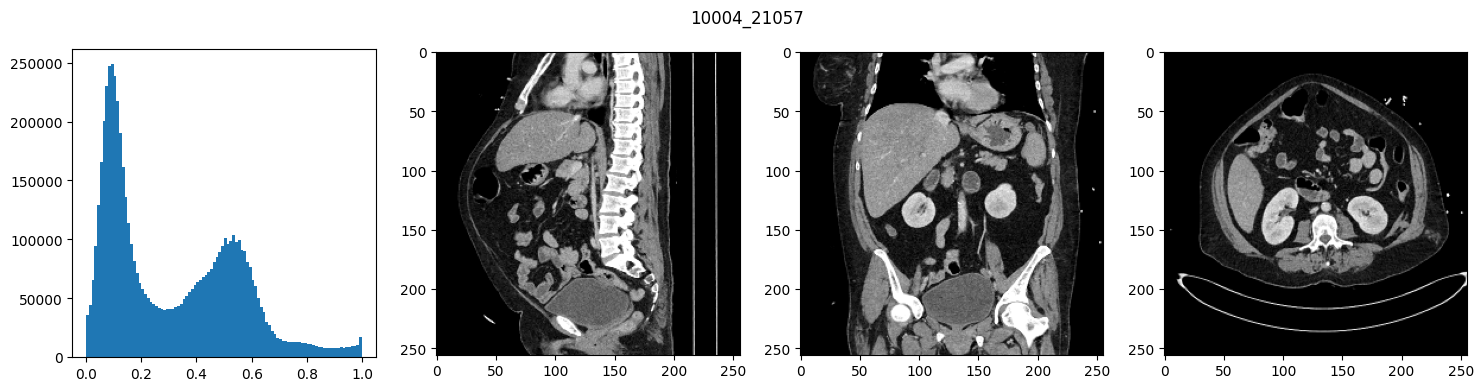

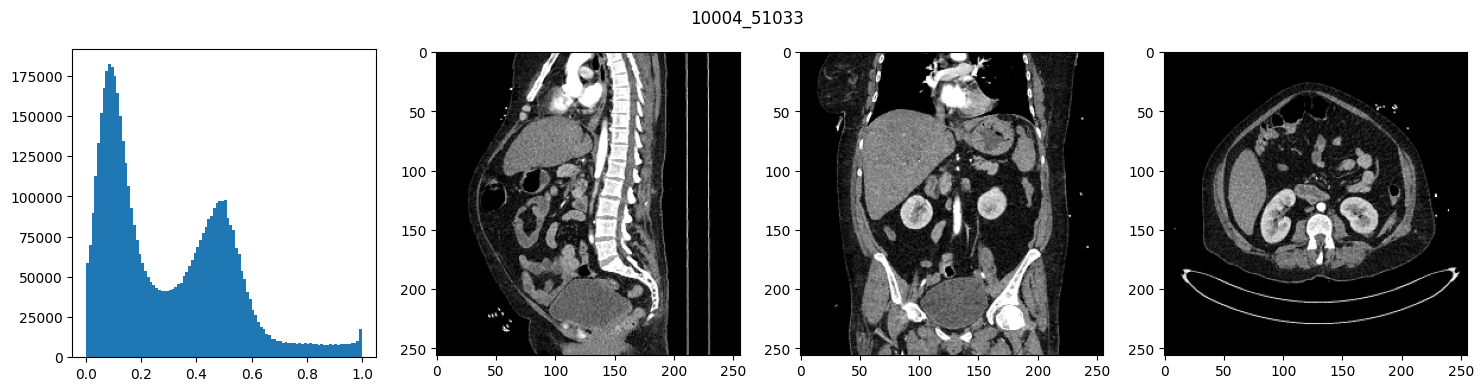

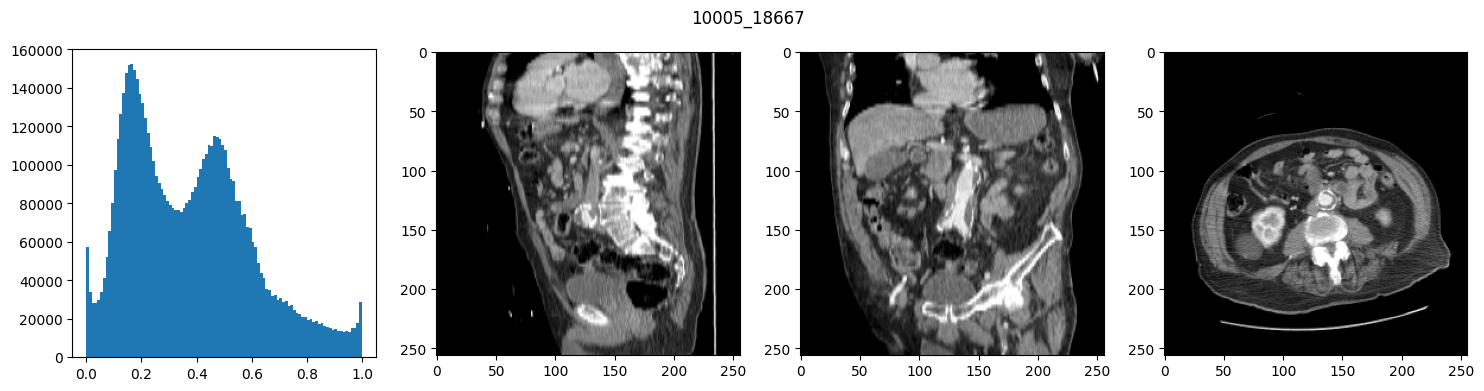

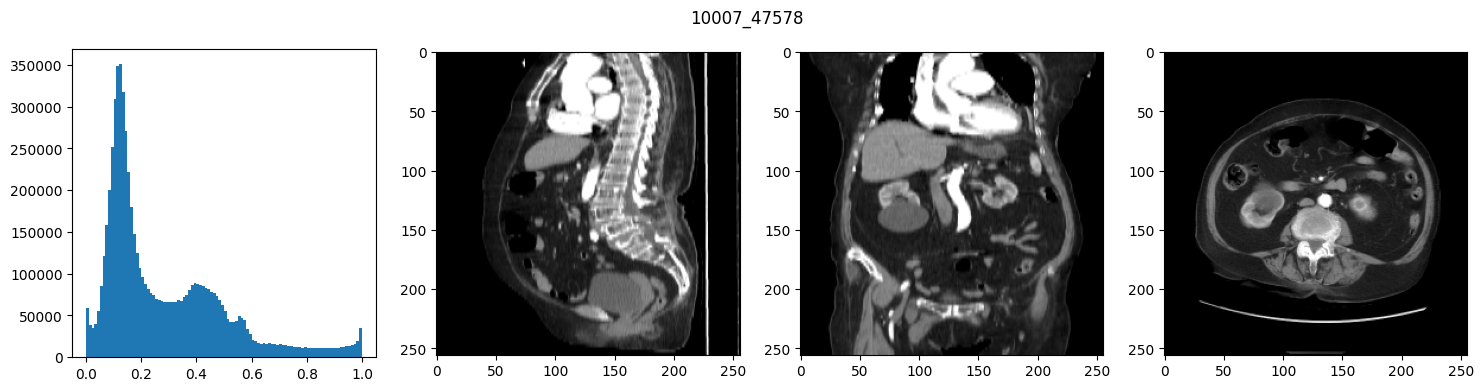

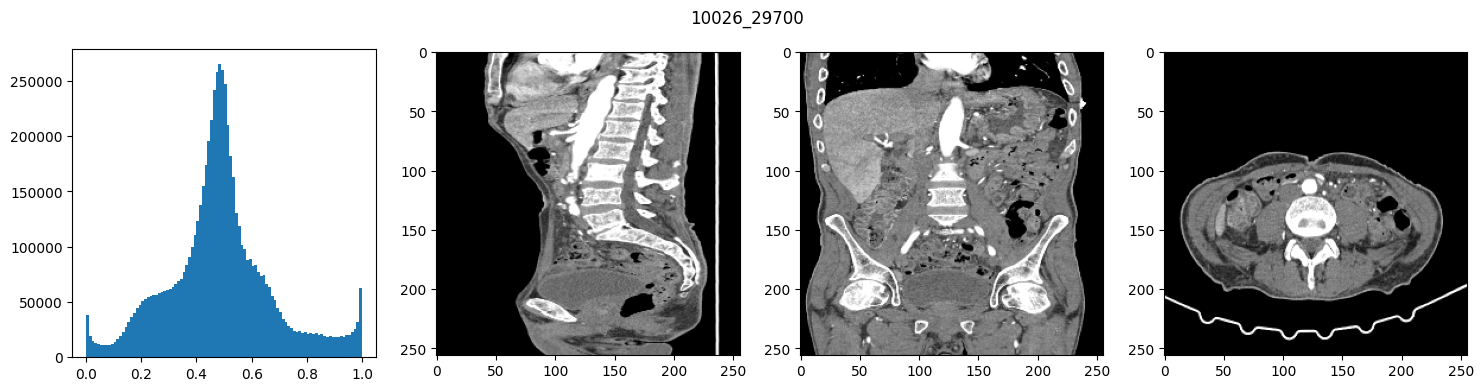

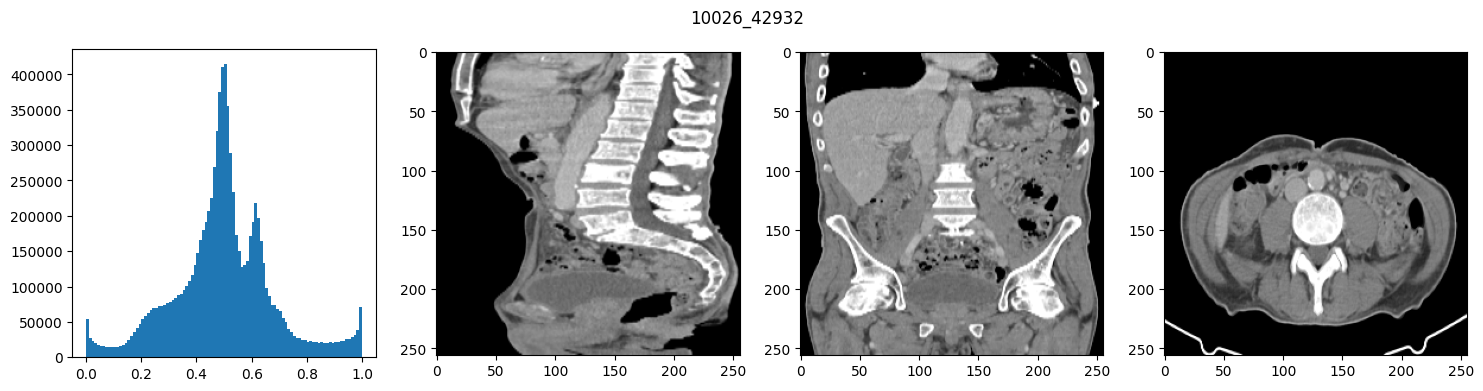

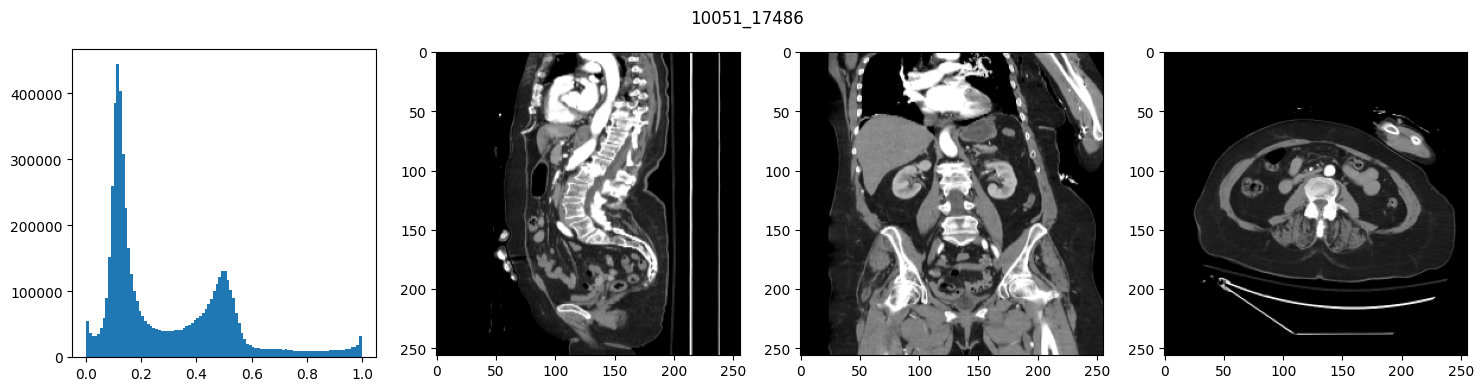

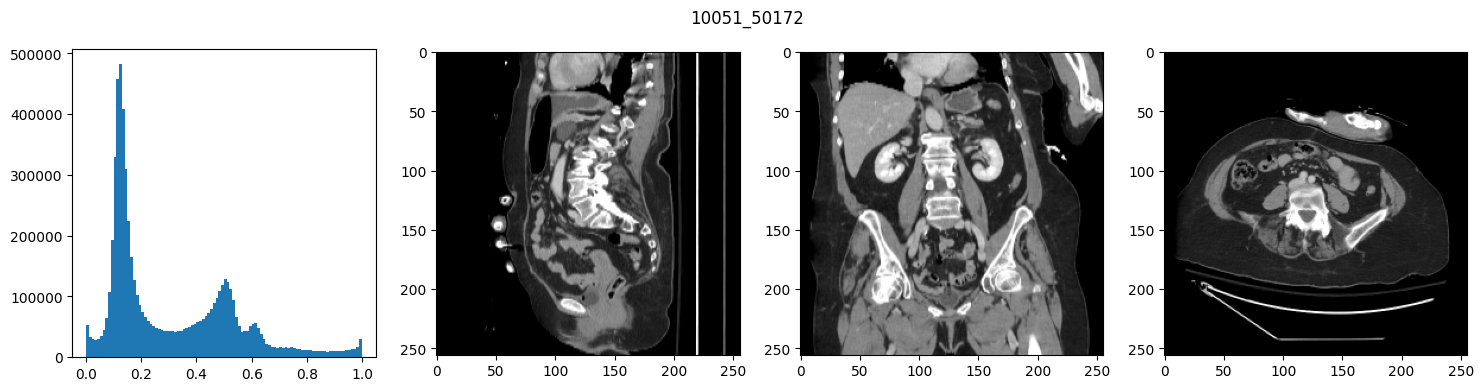

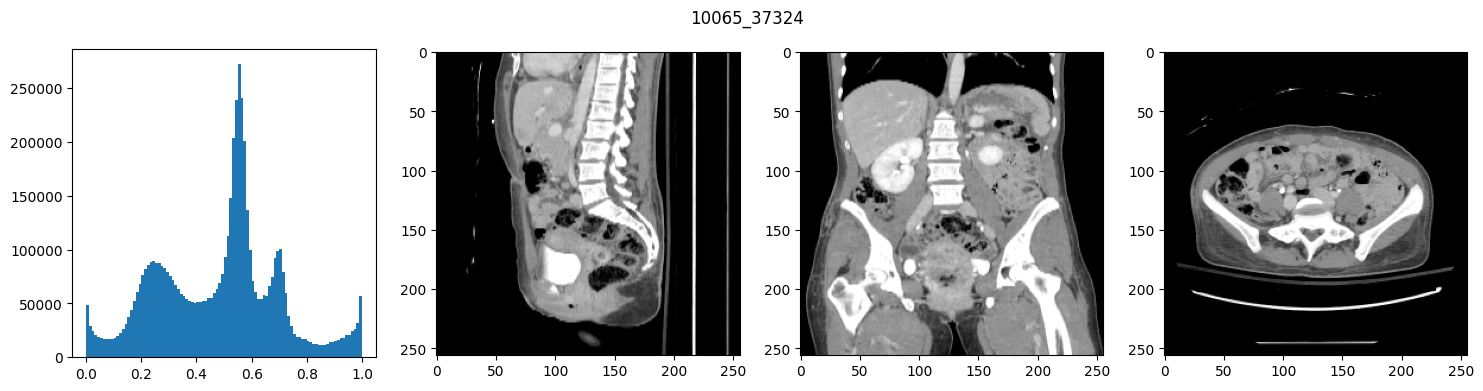

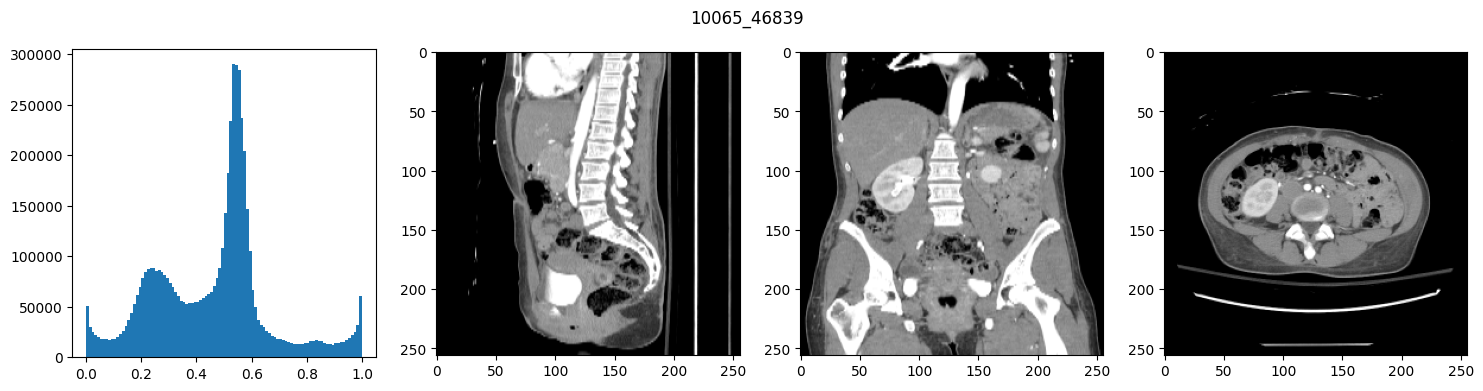

In [7]:
for i,npy_path in enumerate(glob("/kaggle/dataset/volume_256/*.npy")):
    if i<10:
        data=np.load(npy_path)
        fig,ax=plt.subplots(1,4,figsize=(18,4))
        fig.suptitle(npy_path.split("/")[-1].split(".")[0])
        ax[0].hist(data.flatten(),bins=100, range=(0.0001,0.999))
        ax[1].imshow(data[:,:,128],cmap="gray")
        ax[2].imshow(data[:,128,:],cmap="gray")
        ax[3].imshow(data[128,:,:],cmap="gray")
        # break